# **BERT**

Using device: cuda
Detected 2 classes: ['0', '1']
Train: 4796 | Val: 599 | Test: 600


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

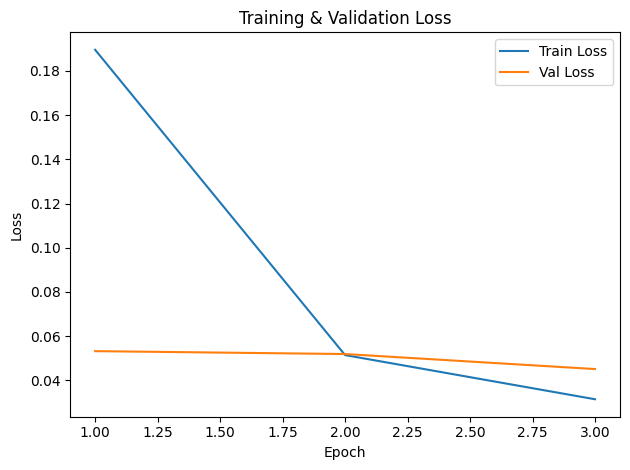

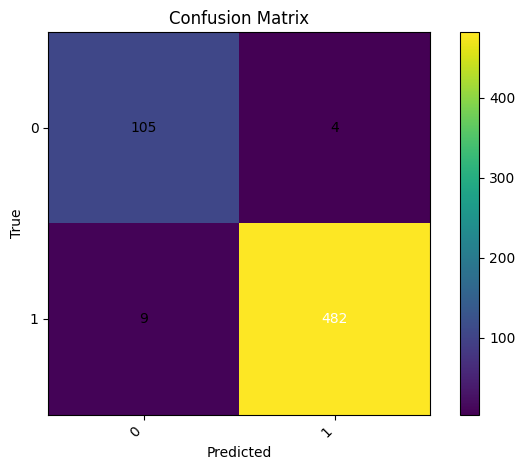

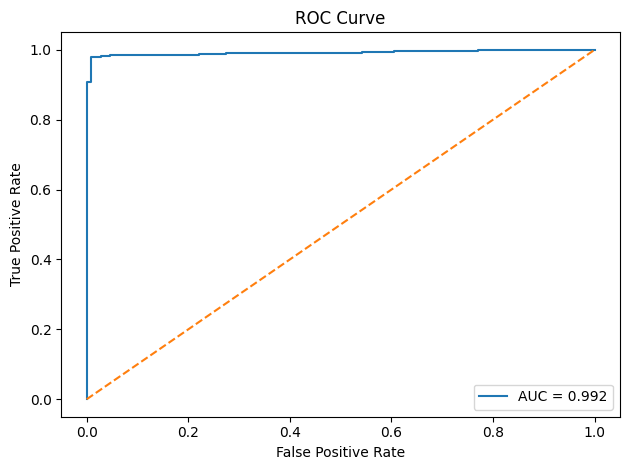

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, roc_auc_score 
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# -----------------------
# Reproducibility helpers
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------
# Config
# -----------------------
CSV_PATH = "twitter_df_engineered.csv"  # <- your uploaded file
TEXT_COL = "tweets"
LABEL_COL = "label"
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1   # 10% warmup
WEIGHT_DECAY = 0.01

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# Load & prep data
# -----------------------
df = pd.read_csv(CSV_PATH)

# Keep rows with actual text
df = df[df[TEXT_COL].notna()]
df = df[df[TEXT_COL].str.strip().str.lower() != "nil"]

# Ensure labels are numeric (if strings, encode them)
if not np.issubdtype(df[LABEL_COL].dtype, np.number):
    le = LabelEncoder()
    df[LABEL_COL] = le.fit_transform(df[LABEL_COL].astype(str))
    class_names = [str(c) for c in le.classes_]
else:
    # Make readable class names from unique numeric labels
    uniq = sorted(df[LABEL_COL].unique().tolist())
    class_names = [str(c) for c in uniq]

num_labels = len(set(df[LABEL_COL].tolist()))
print(f"Detected {num_labels} classes:", class_names)

# Train/Val/Test split (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    df[TEXT_COL].tolist(), df[LABEL_COL].tolist(),
    test_size=0.2, random_state=42, stratify=df[LABEL_COL].tolist()
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# -----------------------
# Dataset / Dataloader
# -----------------------
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDS(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDS(X_val,   y_val,   tokenizer, MAX_LEN)
test_ds  = TextDS(X_test,  y_test,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH_SIZE,   shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=VAL_BATCH_SIZE,   shuffle=False, drop_last=False)

# -----------------------
# Model, Optim, Scheduler
# -----------------------
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)
print(model)  # print model architecture

# Classic AdamW + linear warmup/decay
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------
# Train / Eval loops
# -----------------------
def run_epoch(dataloader, train: bool = True):
    model.train() if train else model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    for batch in dataloader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        with torch.set_grad_enabled(train):
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_count += labels.size(0)

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

# -----------------------
# Test evaluation
# -----------------------
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

y_pred = np.argmax(all_logits, axis=1)
test_acc = accuracy_score(all_labels, y_pred)
print(f"\nTEST Accuracy: {test_acc:.4f}")

# Classification report
# If labels were encoded, class_names holds strings; otherwise make them
if len(class_names) != num_labels:
    # fallback (shouldn't happen)
    class_names = [str(i) for i in range(num_labels)]
print("\nClassification Report:\n")
print(classification_report(all_labels, y_pred, target_names=class_names, digits=4))

# -----------------------
# Plots
# -----------------------

# 1) Training vs Validation Loss
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout()
plt.show()

# 2) Confusion Matrix
cm = confusion_matrix(all_labels, y_pred, labels=list(range(num_labels)))
plt.figure()
im = plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar(im)
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
# Annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# 3) ROC Curve (binary or multiclass One-vs-Rest)
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

plt.figure()
if num_labels == 2:
    fpr, tpr, _ = roc_curve(all_labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
else:
    # One-vs-Rest micro-average
    y_bin = label_binarize(all_labels, classes=list(range(num_labels)))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC={roc_auc[i]:.3f})")
    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"Micro Avg (AUC={roc_auc['micro']:.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# **Roberta**

Using device: cuda
Detected 2 classes: ['0', '1']
Train: 4796 | Val: 599 | Test: 600


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

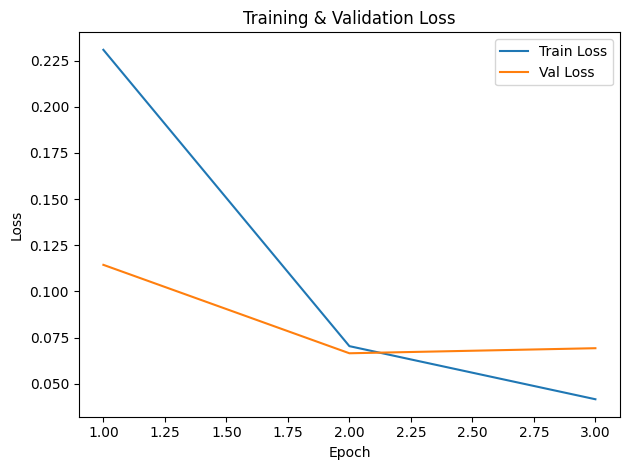

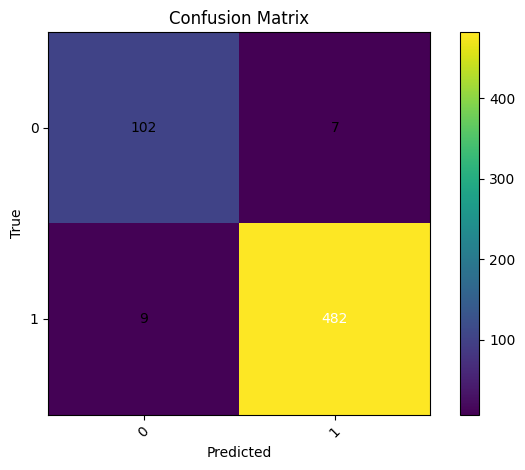

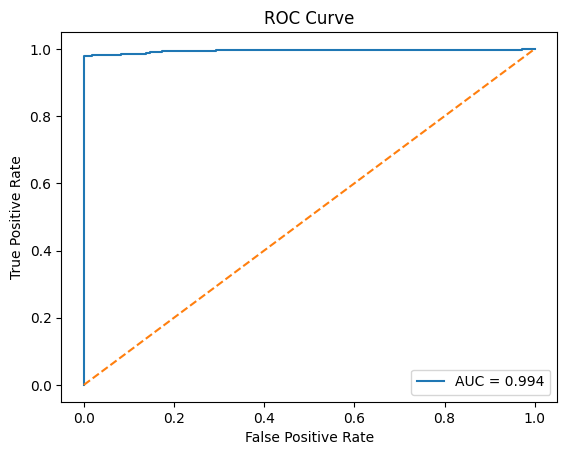

In [3]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt

from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# -----------------------
# Reproducibility helpers
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------
# Config
# -----------------------
CSV_PATH = "twitter_df_engineered.csv"  # dataset path
TEXT_COL = "tweets"
LABEL_COL = "label"
MODEL_NAME = "roberta-base"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# Load & prep data
# -----------------------
df = pd.read_csv(CSV_PATH)

df = df[df[TEXT_COL].notna()]
df = df[df[TEXT_COL].str.strip().str.lower() != "nil"]

if not np.issubdtype(df[LABEL_COL].dtype, np.number):
    le = LabelEncoder()
    df[LABEL_COL] = le.fit_transform(df[LABEL_COL].astype(str))
    class_names = [str(c) for c in le.classes_]
else:
    uniq = sorted(df[LABEL_COL].unique().tolist())
    class_names = [str(c) for c in uniq]

num_labels = len(set(df[LABEL_COL].tolist()))
print(f"Detected {num_labels} classes:", class_names)

X_train, X_temp, y_train, y_temp = train_test_split(
    df[TEXT_COL].tolist(), df[LABEL_COL].tolist(),
    test_size=0.2, random_state=42, stratify=df[LABEL_COL].tolist()
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# -----------------------
# Dataset / Dataloader
# -----------------------
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDS(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDS(X_val,   y_val,   tokenizer, MAX_LEN)
test_ds  = TextDS(X_test,  y_test,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=VAL_BATCH_SIZE)

# -----------------------
# Model, Optimizer, Scheduler
# -----------------------
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)
print(model)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------
# Train / Eval loops
# -----------------------
def run_epoch(dataloader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.set_grad_enabled(train):
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_count += labels.size(0)

    return total_loss / total_count, total_correct / total_count

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

# -----------------------
# Test evaluation
# -----------------------
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits)
all_labels = np.concatenate(all_labels)
y_pred = np.argmax(all_logits, axis=1)
test_acc = accuracy_score(all_labels, y_pred)
print(f"\nTEST Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, y_pred, target_names=class_names, digits=4))

# -----------------------
# Plots
# -----------------------
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

cm = confusion_matrix(all_labels, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.tight_layout(); plt.show()

# ROC curve
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
plt.figure()
if num_labels == 2:
    fpr, tpr, _ = roc_curve(all_labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
else:
    y_bin = label_binarize(all_labels, classes=list(range(num_labels)))
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.show()


# **DistilBERT**

Using device: cuda
Detected 2 classes: ['0', '1']
Train: 4796 | Val: 599 | Test: 600


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


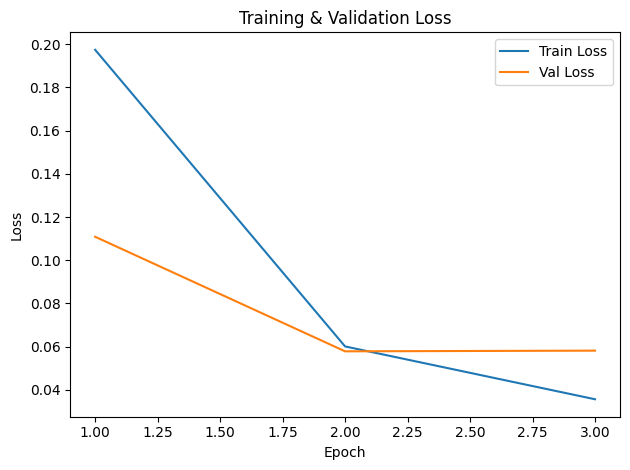

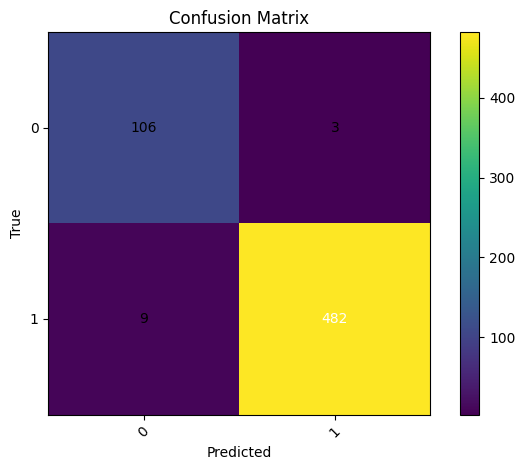

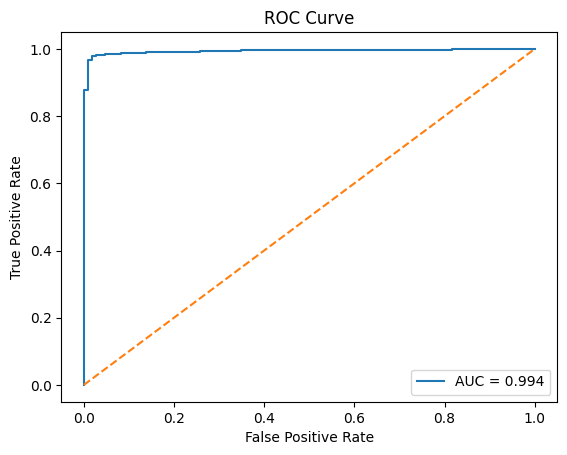

In [4]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# -----------------------
# Reproducibility helpers
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------
# Config
# -----------------------
CSV_PATH = "twitter_df_engineered.csv"  # dataset path
TEXT_COL = "tweets"
LABEL_COL = "label"
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# Load & prep data
# -----------------------
df = pd.read_csv(CSV_PATH)

df = df[df[TEXT_COL].notna()]
df = df[df[TEXT_COL].str.strip().str.lower() != "nil"]

if not np.issubdtype(df[LABEL_COL].dtype, np.number):
    le = LabelEncoder()
    df[LABEL_COL] = le.fit_transform(df[LABEL_COL].astype(str))
    class_names = [str(c) for c in le.classes_]
else:
    uniq = sorted(df[LABEL_COL].unique().tolist())
    class_names = [str(c) for c in uniq]

num_labels = len(set(df[LABEL_COL].tolist()))
print(f"Detected {num_labels} classes:", class_names)

X_train, X_temp, y_train, y_temp = train_test_split(
    df[TEXT_COL].tolist(), df[LABEL_COL].tolist(),
    test_size=0.2, random_state=42, stratify=df[LABEL_COL].tolist()
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# -----------------------
# Dataset / Dataloader
# -----------------------
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDS(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDS(X_val,   y_val,   tokenizer, MAX_LEN)
test_ds  = TextDS(X_test,  y_test,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=VAL_BATCH_SIZE)

# -----------------------
# Model, Optimizer, Scheduler
# -----------------------
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)
print(model)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------
# Train / Eval loops
# -----------------------
def run_epoch(dataloader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.set_grad_enabled(train):
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_count += labels.size(0)

    return total_loss / total_count, total_correct / total_count

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

# -----------------------
# Test evaluation
# -----------------------
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits)
all_labels = np.concatenate(all_labels)
y_pred = np.argmax(all_logits, axis=1)
test_acc = accuracy_score(all_labels, y_pred)
print(f"\nTEST Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, y_pred, target_names=class_names, digits=4))

# -----------------------
# Plots
# -----------------------
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

cm = confusion_matrix(all_labels, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.tight_layout(); plt.show()

# ROC curve
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
plt.figure()
if num_labels == 2:
    fpr, tpr, _ = roc_curve(all_labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
else:
    y_bin = label_binarize(all_labels, classes=list(range(num_labels)))
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.show()


# **XLNet**

Using device: cuda
Detected 2 classes: ['0', '1']
Train: 4796 | Val: 599 | Test: 600


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): XLNetSequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Epoch 1/3 | Train Loss: 0.1958 Acc: 0.9316 | Val Loss: 0.1032 Acc: 0.9833
Epoch 2/3 | Train Loss: 0.0735 Acc: 0.9814 | Val Loss: 0.0547 Acc: 0.9883
Epoch 3/3 | Train Loss: 0.0408 Acc: 0.9892 | Val Loss: 0.0643 Acc: 0.9850

TEST Accuracy: 0.9733

Classification Report:

              precision    recall  f1-score   support

           0     0.9043    0.9541    0.9286       109
           1     0.9897    0.9776    0.9836       491

    accuracy                         0.9733       600
   macro avg     0.9470    0.9659    0.9561       600
weighted avg     0.9742    0.9733    0.9736       600



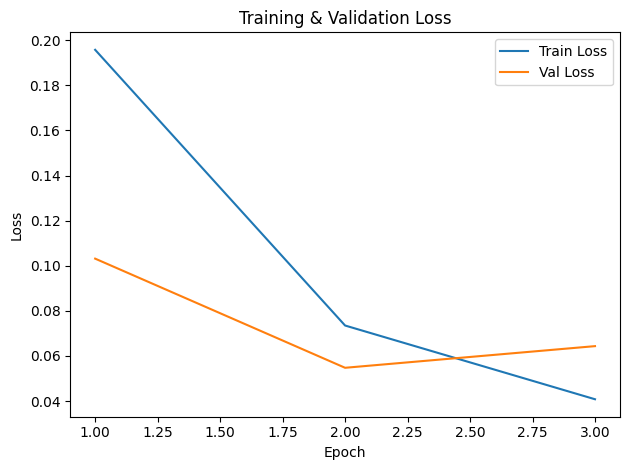

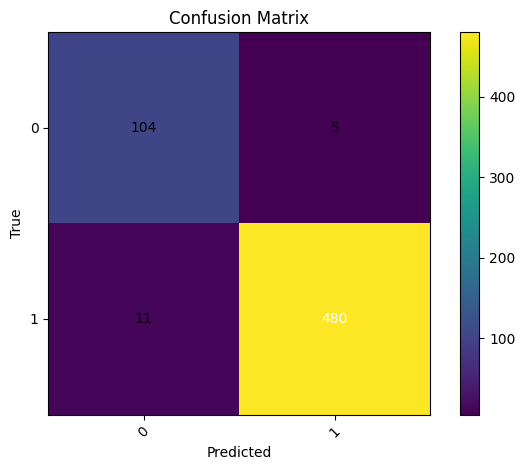

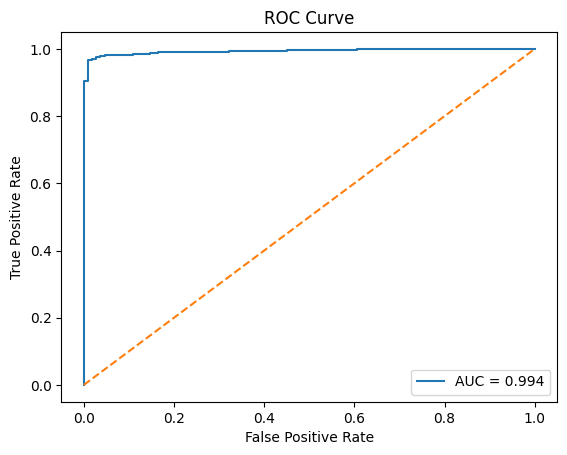

In [5]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt

from transformers import XLNetTokenizer, XLNetForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# -----------------------
# Reproducibility helpers
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------
# Config
# -----------------------
CSV_PATH = "twitter_df_engineered.csv"  # dataset path
TEXT_COL = "tweets"
LABEL_COL = "label"
MODEL_NAME = "xlnet-base-cased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# Load & prep data
# -----------------------
df = pd.read_csv(CSV_PATH)

df = df[df[TEXT_COL].notna()]
df = df[df[TEXT_COL].str.strip().str.lower() != "nil"]

if not np.issubdtype(df[LABEL_COL].dtype, np.number):
    le = LabelEncoder()
    df[LABEL_COL] = le.fit_transform(df[LABEL_COL].astype(str))
    class_names = [str(c) for c in le.classes_]
else:
    uniq = sorted(df[LABEL_COL].unique().tolist())
    class_names = [str(c) for c in uniq]

num_labels = len(set(df[LABEL_COL].tolist()))
print(f"Detected {num_labels} classes:", class_names)

X_train, X_temp, y_train, y_temp = train_test_split(
    df[TEXT_COL].tolist(), df[LABEL_COL].tolist(),
    test_size=0.2, random_state=42, stratify=df[LABEL_COL].tolist()
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# -----------------------
# Dataset / Dataloader
# -----------------------
tokenizer = XLNetTokenizer.from_pretrained(MODEL_NAME)

class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDS(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDS(X_val,   y_val,   tokenizer, MAX_LEN)
test_ds  = TextDS(X_test,  y_test,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=VAL_BATCH_SIZE)

# -----------------------
# Model, Optimizer, Scheduler
# -----------------------
model = XLNetForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)
print(model)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------
# Train / Eval loops
# -----------------------
def run_epoch(dataloader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.set_grad_enabled(train):
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_count += labels.size(0)

    return total_loss / total_count, total_correct / total_count

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

# -----------------------
# Test evaluation
# -----------------------
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits)
all_labels = np.concatenate(all_labels)
y_pred = np.argmax(all_logits, axis=1)
test_acc = accuracy_score(all_labels, y_pred)
print(f"\nTEST Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, y_pred, target_names=class_names, digits=4))

# -----------------------
# Plots
# -----------------------
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

cm = confusion_matrix(all_labels, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.tight_layout(); plt.show()

# ROC curve
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
plt.figure()
if num_labels == 2:
    fpr, tpr, _ = roc_curve(all_labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
else:
    y_bin = label_binarize(all_labels, classes=list(range(num_labels)))
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.show()


# **T5-Small**

Using device: cuda
Detected 2 classes: ['0', '1']
Train: 4796 | Val: 599 | Test: 600


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): XLNetSequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    

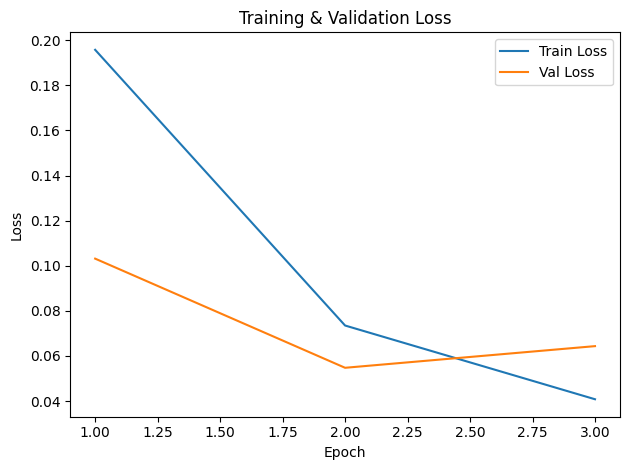

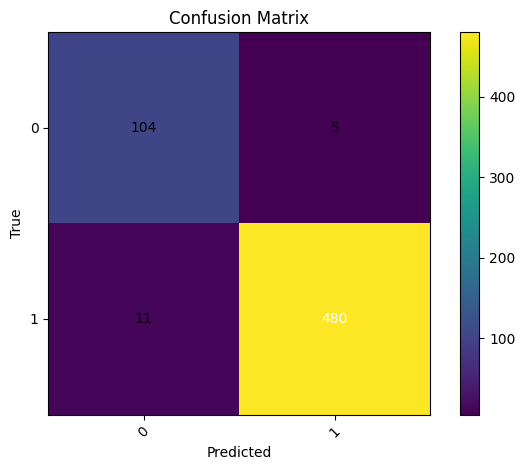

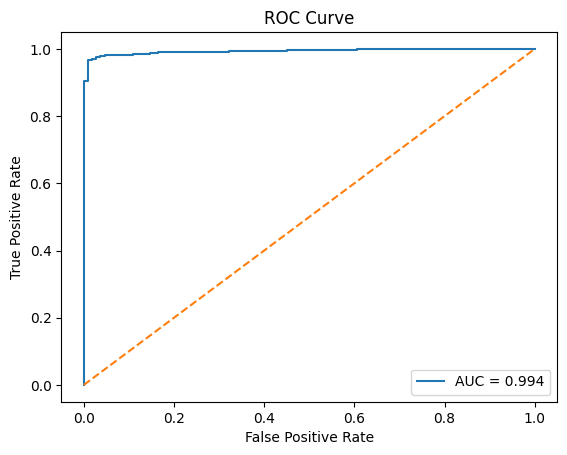

In [10]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt

from transformers import XLNetTokenizer, XLNetForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# -----------------------
# Reproducibility helpers
# -----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------
# Config
# -----------------------
CSV_PATH = "twitter_df_engineered.csv"  # dataset path
TEXT_COL = "tweets"
LABEL_COL = "label"
MODEL_NAME = "xlnet-base-cased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# -----------------------
# Device
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# Load & prep data
# -----------------------
df = pd.read_csv(CSV_PATH)

df = df[df[TEXT_COL].notna()]
df = df[df[TEXT_COL].str.strip().str.lower() != "nil"]

if not np.issubdtype(df[LABEL_COL].dtype, np.number):
    le = LabelEncoder()
    df[LABEL_COL] = le.fit_transform(df[LABEL_COL].astype(str))
    class_names = [str(c) for c in le.classes_]
else:
    uniq = sorted(df[LABEL_COL].unique().tolist())
    class_names = [str(c) for c in uniq]

num_labels = len(set(df[LABEL_COL].tolist()))
print(f"Detected {num_labels} classes:", class_names)

X_train, X_temp, y_train, y_temp = train_test_split(
    df[TEXT_COL].tolist(), df[LABEL_COL].tolist(),
    test_size=0.2, random_state=42, stratify=df[LABEL_COL].tolist()
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# -----------------------
# Dataset / Dataloader
# -----------------------
tokenizer = XLNetTokenizer.from_pretrained(MODEL_NAME)

class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDS(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDS(X_val,   y_val,   tokenizer, MAX_LEN)
test_ds  = TextDS(X_test,  y_test,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=VAL_BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=VAL_BATCH_SIZE)

# -----------------------
# Model, Optimizer, Scheduler
# -----------------------
model = XLNetForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)
print(model)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# -----------------------
# Train / Eval loops
# -----------------------
def run_epoch(dataloader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.set_grad_enabled(train):
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * labels.size(0)
        # Convert logits (which are per-token) to predictions (for classification)
        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_count += labels.size(0)

    return total_loss / total_count, total_correct / total_count

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

# -----------------------
# Test evaluation
# -----------------------
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits)
all_labels = np.concatenate(all_labels)
y_pred = np.argmax(all_logits, axis=1)
test_acc = accuracy_score(all_labels, y_pred)
print(f"\nTEST Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, y_pred, target_names=class_names, digits=4))

# -----------------------
# Plots
# -----------------------
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

cm = confusion_matrix(all_labels, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.tight_layout(); plt.show()

# ROC curve
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
plt.figure()
if num_labels == 2:
    fpr, tpr, _ = roc_curve(all_labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
else:
    y_bin = label_binarize(all_labels, classes=list(range(num_labels)))
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.show()
